In [73]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
import pickle
from skimage import io
from extract_features import extract_features

In [74]:
# Where is the raw provided data
file_data_good = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Good.csv"
file_data_mixed = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Mixed.csv"
file_data_bad = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Bad.csv"

image_folders = [
    r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingGood",
    r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingMixed",
    r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingBad"
]

# Where we will store the features
file_features_good = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Good_features.csv"
file_features_mixed = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Mixed_features.csv"
file_features_bad = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Bad_features.csv"

def process_images(file_data, image_folder, file_features):
    # Read meta-data into a Pandas dataframe
    df = pd.read_csv(file_data)

    # Extract features from the image folder
    features_df = extract_features_folder(image_folder)

    # Merge the features DataFrame with the diagnostic column from the original DataFrame
    df_merged = pd.merge(df[['img_id', 'diagnostic']], features_df, on='img_id', how='inner')
    
    # Create the directory if it doesn't exist
    directory = os.path.dirname(file_features)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    df_merged.to_csv(file_features, index=False)
    print(f"Processed Images in {image_folder}: Done")

def extract_features_folder(path_image):
    features = []

    for filename in os.listdir(path_image):
        if filename.endswith(('.jpg', '.png')):
            img_id = os.path.splitext(filename)[0]  # Remove file extension
            image_path = os.path.join(path_image, filename)
            image = io.imread(image_path)

            image_features = extract_features(image)
            image_features["img_id"] = img_id
            features.append(image_features)

    features_df = pd.DataFrame(features)
    return features_df

# Process images for each set
process_images(file_data_good, image_folders[0], file_features_good)
process_images(file_data_mixed, image_folders[1], file_features_mixed)
process_images(file_data_bad, image_folders[2], file_features_bad)

Processed Images in C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingGood: Done
Processed Images in C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingMixed: Done
Processed Images in C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingBad: Done


In [89]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

def get_metrics(classifiers, x, y, patient_id):
    num_folds = 5
    num_classifiers = len(classifiers)
    acc_val = np.empty([num_folds, num_classifiers])
    f1_val = np.empty([num_folds, num_classifiers])
    precision = np.empty([num_folds, num_classifiers])
    recall = np.empty([num_folds, num_classifiers])
    roc_auc = np.empty([num_folds, num_classifiers])
    
    group_kfold = GroupKFold(n_splits=num_folds)
    for i, (train_index, val_index) in enumerate(group_kfold.split(x, y, patient_id)):
        x_train, x_val = x[train_index, :], x[val_index, :]
        y_train, y_val = y[train_index], y[val_index]
        for j, clf in enumerate(classifiers):
            clf.fit(x_train, y_train)
            predictions = clf.predict(x_val)
            acc_val[i, j] = accuracy_score(y_val, predictions)
            f1_val[i, j] = f1_score(y_val, predictions)
            precision[i, j] = precision_score(y_val, predictions, zero_division=0)
            recall[i, j] = recall_score(y_val, predictions)
            roc_auc[i, j] = roc_auc_score(y_val, predictions)

    return acc_val, f1_val, precision, recall, roc_auc


# Define absolute paths for the features
absolute_paths = [r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Good_features.csv", r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\mixed_features.csv", r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\bad_features.csv"]
datasets = ['Good', 'Mixed', 'Bad']

# Define classifiers
classifiers = [KNN(5), LR(max_iter=5000), DTC()]
classifier_names = ["KNN", "LR", "DTC"]

# Initialize an empty dataframe to store all the results
all_results = pd.DataFrame()

# Loop over datasets
for absolute_path, dataset in zip(absolute_paths, datasets):
    print(f"Processing {dataset} dataset...")
    # Read data
    df_merged = pd.read_csv(absolute_path)
    x = np.array(df_merged.drop(['img_id', 'diagnostic'], axis=1))
    y = df_merged['diagnostic']
    patient_id = df_merged['img_id']

    # Define different feature selection methods
    pca = PCA(n_components=5)
    x_pca = pca.fit_transform(x)
    var_thresh = VarianceThreshold(threshold=0.1)
    x_var = var_thresh.fit_transform(x)

    feature_selections = {
        "None": x,
        "Variance Threshold": x_var,
        "PCA": x_pca
    }

    feature_selection_models = {
        "None": None,
        "Variance Threshold": var_thresh,
        "PCA": pca
    }

    # Loop over feature selections
    for feature_selection_name, x_selected in feature_selections.items():
        # Get performance metrics
        acc_val, f1_val, precision, recall, roc_auc = get_metrics(classifiers, x_selected, y, patient_id)

        # Loop over classifiers
        for j, clf_name in enumerate(classifier_names):
            # Prepare the results for this classifier and feature selection method
            results = {
                "Dataset": dataset,
                "Feature Selection": feature_selection_name,
                "Classifier": clf_name,
                "F1 Score": np.mean(f1_val[:, j]),
                "Accuracy": np.mean(acc_val[:, j]),
               "Precision": np.mean(precision[:, j]),
                "Recall": np.mean(recall[:, j]),
                "ROC AUC": np.mean(roc_auc[:, j])
            }
            # Append the results to the dataframe
            all_results = all_results.append(results, ignore_index=True)

            # Fit the classifier on the selected features
            classifier = classifiers[j].fit(x_selected, y)

            # Create a directory if it does not exist
            model_dir = fr"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/{dataset}/{feature_selection_name}"
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)

            # Save the classifier
            model_path = f"{model_dir}/{clf_name}_model.pkl"
            pickle.dump(classifier, open(model_path, 'wb'))
            print(f"Saved {clf_name} model for {dataset} dataset with {feature_selection_name} feature selection at {model_path}.")


Processing Good dataset...
Saved KNN model for Good dataset with None feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/None/KNN_model.pkl.
Saved LR model for Good dataset with None feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/None/LR_model.pkl.
Saved DTC model for Good dataset with None feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/None/DTC_model.pkl.
Saved KNN model for Good dataset with Variance Threshold feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/Variance Threshold/KNN_model.pkl.
Saved LR model for Good dataset with Variance Threshold feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/Variance Threshold/LR_model.pkl.
Saved DTC model for Good dataset with Variance Threshold feature select

In [90]:
all_results 

,Dataset,Feature Selection,Classifier,F1 Score,Accuracy,Precision,Recall,ROC AUC
0,Good,None,KNN,0.801014,0.714286,0.771225,0.853634,0.652661
1,Good,None,LR,0.866859,0.819048,0.846891,0.903950,0.795286
2,Good,None,DTC,0.783931,0.695238,0.773144,0.817605,0.643218
3,Good,Variance Threshold,KNN,0.801014,0.714286,0.771225,0.853634,0.652661
4,Good,Variance Threshold,LR,0.866859,0.819048,0.846891,0.903950,0.795286
5,Good,Variance Threshold,DTC,0.782926,0.704762,0.784231,0.798340,0.662677
6,Good,PCA,KNN,0.801014,0.714286,0.771225,0.853634,0.652661
7,Good,PCA,LR,0.860811,0.809524,0.834391,0.903950,0.775286
8,Good,PCA,DTC,0.832177,0.771429,0.843586,0.840399,0.741368
9,Mixed,None,KNN,0.725902,0.649565,0.707633,0.749908,0.609605


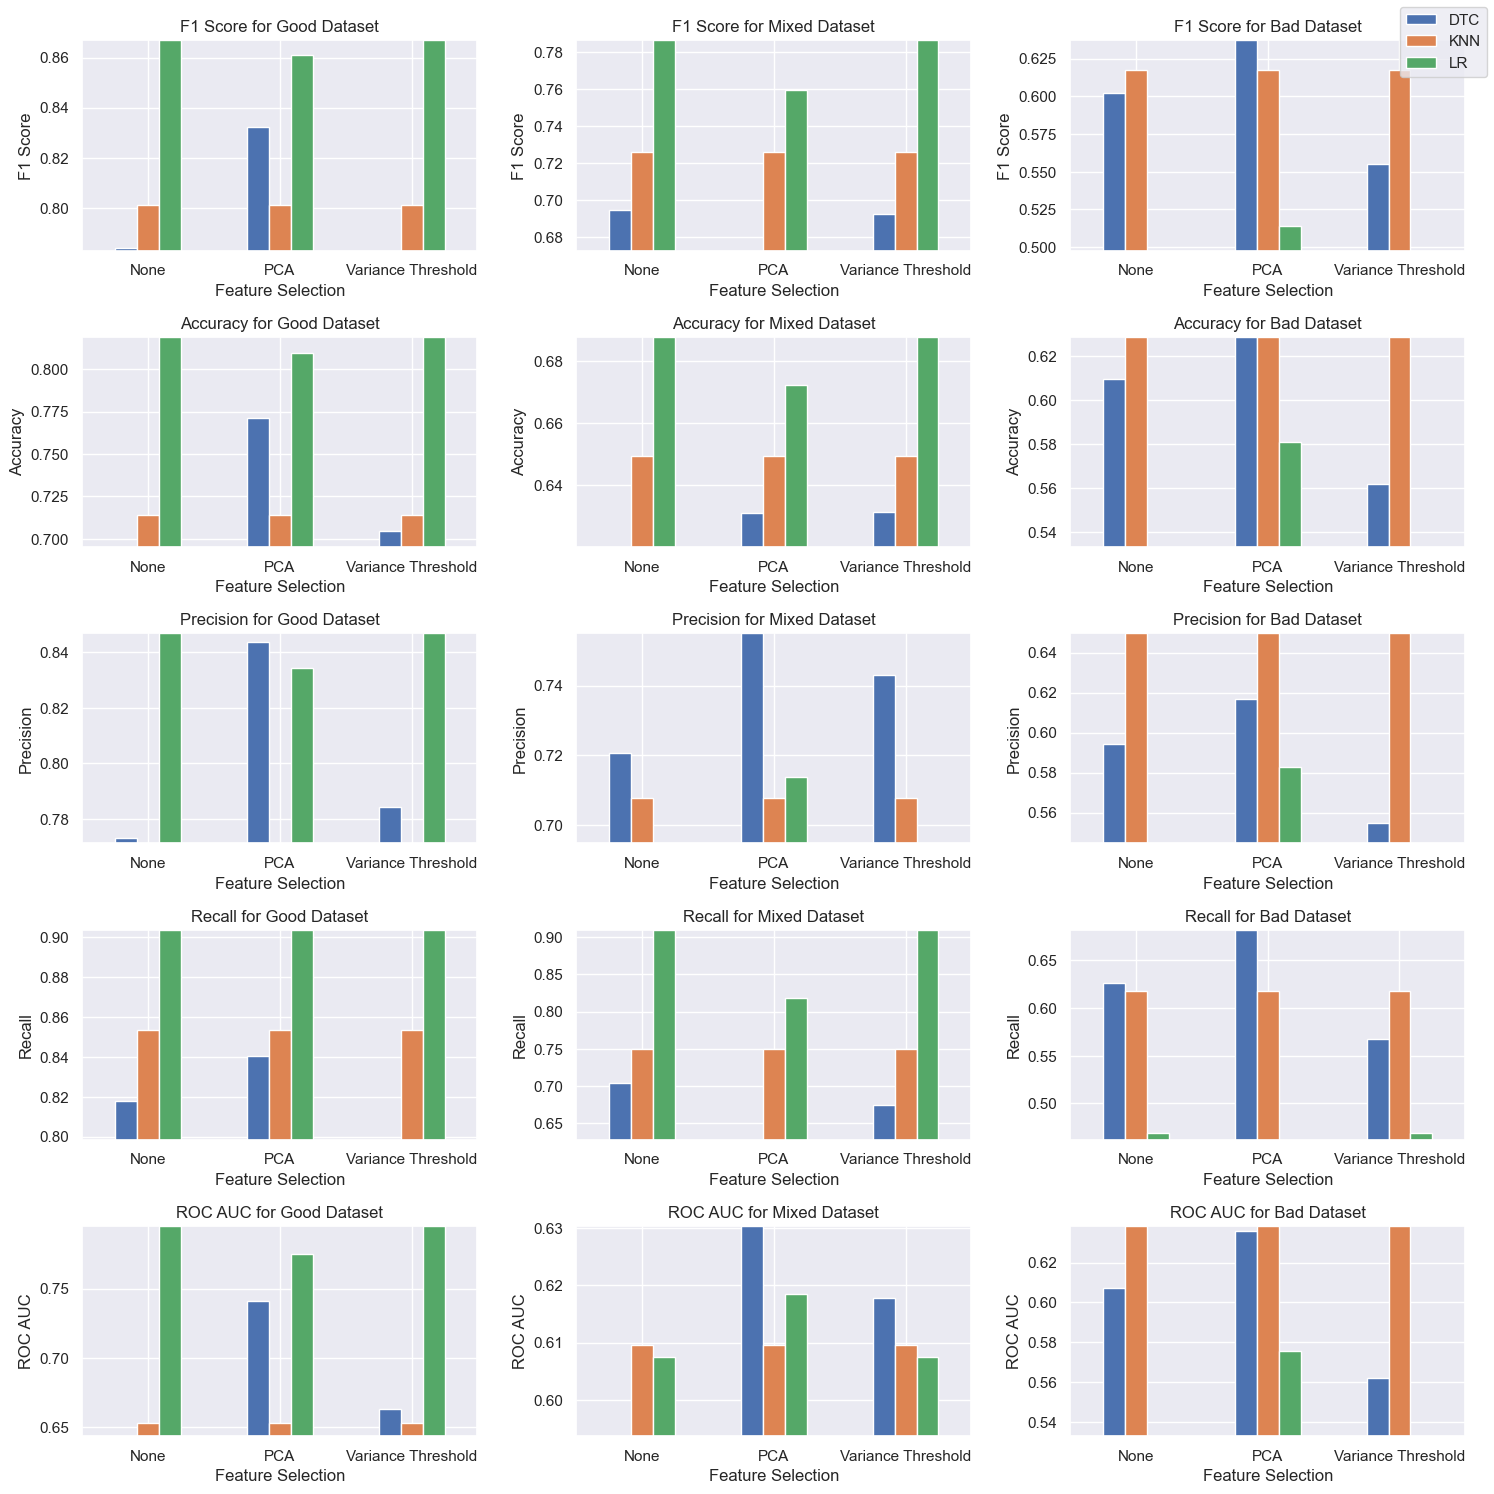

Best configuration for F1 Score:
Dataset                  Good
Feature Selection        None
Classifier                 LR
F1 Score             0.866859
Accuracy             0.819048
Precision            0.846891
Recall                0.90395
ROC AUC              0.795286
Name: 1, dtype: object
Best configuration for Accuracy:
Dataset                  Good
Feature Selection        None
Classifier                 LR
F1 Score             0.866859
Accuracy             0.819048
Precision            0.846891
Recall                0.90395
ROC AUC              0.795286
Name: 1, dtype: object
Best configuration for Precision:
Dataset                  Good
Feature Selection        None
Classifier                 LR
F1 Score             0.866859
Accuracy             0.819048
Precision            0.846891
Recall                0.90395
ROC AUC              0.795286
Name: 1, dtype: object
Best configuration for Recall:
Dataset                 Mixed
Feature Selection        None
Classifier          

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

datasets = all_results['Dataset'].unique()
metrics = ['F1 Score', 'Accuracy', 'Precision', 'Recall', 'ROC AUC']

# Define the layout for subplots
num_rows = len(metrics)
num_cols = len(datasets)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, metric in enumerate(metrics):
    for j, dataset in enumerate(datasets):
        subset = all_results[all_results['Dataset'] == dataset]
        pivot_table = subset.pivot_table(index='Feature Selection', columns='Classifier', values=metric)
        ax = axes[i, j]  # Get the corresponding subplot
        pivot_table.plot(kind='bar', ax=ax, legend=False)  # Disable legend for individual subplots
        ax.set_title(f'{metric} for {dataset} Dataset')
        ax.set_ylabel(metric)
        ax.set_ylim([pivot_table.min().min(), pivot_table.max().max()])  # set y limits to min and max of each metric
        ax.tick_params(axis='x', rotation=0)  # Set x-axis labels horizontal

# Add a single legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

# You can also find the best configuration for each metric
for metric in metrics:
    best_config = all_results.loc[all_results[metric].idxmax()]
    print(f'Best configuration for {metric}:')
    print(best_config)


**Picture Quality**: The datasets represent different levels of picture quality, including good quality, mixed quality (a combination of good and bad), and bad quality images.

**Feature Selection**: The different feature selection methods evaluated in the dataset are "None," "Variance Threshold," and "PCA." Based on the available data, it is unclear which feature selection method performs best for each picture quality category. Further analysis would be required to determine the most effective feature selection method for each category.

**Classifiers**: The classifiers used in the evaluation are KNN, LR (Logistic Regression), and DTC (Decision Tree Classifier). However, it is not evident from the provided data which classifier performs best for each picture quality category. More information or analysis would be needed to determine the most suitable classifier for different picture qualities.

**Metric Performance**: The metrics used for evaluation are F1 Score, Accuracy, Precision, Recall, and ROC AUC. It can be observed that the models generally achieve higher scores across all metrics for the "good quality" dataset compared to the "mixed quality" and "bad quality" datasets. This suggests that the models perform better on images with higher quality.

In [92]:
import warnings

warnings.filterwarnings("ignore", message="X has feature names")

In [94]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import f1_score
from skimage import io
from extract_features import extract_features

def extract_features_from_image_folder(folder_path):
    features = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png')):
            img_id = os.path.splitext(filename)[0]  # Remove file extension
            image_path = os.path.join(folder_path, filename)
            image = io.imread(image_path)
            image_features = extract_features(image)
            image_features["img_id"] = img_id
            features.append(image_features)
    features_df = pd.DataFrame(features)
    return features_df

def test_models(test_img_folder, csv_path):
    datasets = ['Good', 'Mixed', 'Bad']
    feature_selections = ["None", "Variance Threshold", "PCA"]
    classifier_names = ["KNN", "LR", "DTC"]
    test_results = []

    # Extract features from the test images
    df_test_features = extract_features_from_image_folder(test_img_folder)

    # Load test labels
    df_test_labels = pd.read_csv(csv_path)
    df_test_labels = df_test_labels.drop_duplicates(subset=['img_id'], keep='first')

    # Get image ids from test set
    image_ids = [os.path.splitext(filename)[0] for filename in os.listdir(test_img_folder)]

    # Filter df_test_labels so it only includes labels for images in the test set
    df_test_labels = df_test_labels[df_test_labels['img_id'].isin(image_ids)]

    # Get the labels as a numpy array
    y_test = df_test_labels['diagnostic'].values


    duplicates = df_test_labels[df_test_labels.duplicated(['img_id'], keep=False)]


    # Loop over datasets
    for dataset in datasets:
        # Loop over feature selections
        for feature_selection in feature_selections:
            # Loop over classifiers
            for clf_name in classifier_names:
                # Load classifier
                model_dir = fr"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/{dataset}/{feature_selection}"
                model_path = f"{model_dir}/{clf_name}_model.pkl"
                clf = pickle.load(open(model_path, 'rb'))

                # If feature selection was used, transform the test features
                if feature_selection != "None":
                    feature_selection_model_path = f"{model_dir}/{feature_selection.lower()}_model.pkl"
                    feature_selection_model = pickle.load(open(feature_selection_model_path, 'rb'))
                    x_test_transformed = feature_selection_model.transform(df_test_features.drop(columns=['img_id']))

                else:
                    x_test_transformed = df_test_features.drop(columns=['img_id'])

                # Predict the labels for the test data
                y_pred = clf.predict(x_test_transformed)

                # Compute the F1 score
                f1 = f1_score(y_test, y_pred, average='macro')

                # Append results
                test_results.append({
                    "Dataset": dataset,
                    "Feature Selection": feature_selection,
                    "Classifier": clf_name,
                    "F1 Score": f1
                })

    test_results_df = pd.DataFrame(test_results)
    return test_results_df

path_to_good_test_set = r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TestGood'
path_to_mixed_test_set = r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TestMixed'
path_to_bad_test_set = r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TestBad'
csv_path = r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Concatenated.csv'

In [95]:
# Run the tests
test_results_good = test_models(path_to_good_test_set, csv_path)
test_results_mixed = test_models(path_to_mixed_test_set, csv_path)
test_results_bad = test_models(path_to_bad_test_set, csv_path)

# Make the results a dataframe
test_results_good = pd.DataFrame(test_results_good)
test_results_mixed = pd.DataFrame(test_results_mixed)
test_results_bad = pd.DataFrame(test_results_bad)

# add a column to each dataframe to indicate the image quality
test_results_good['Test Quality'] = 'Good'
test_results_mixed['Test Quality'] = 'Mixed'
test_results_bad['Test Quality'] = 'Bad'

# Concatenate the results into a single dataframe
test_results = pd.concat([test_results_good, test_results_mixed, test_results_bad])
test_results
# Save the results to a CSV file
test_results.to_csv(r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\test_results.csv', index=False)

In [96]:
#provide best 3 models based on f1 score
best_models = test_results.sort_values(by='F1 Score', ascending=False).head()
print(best_models)

   Dataset   Feature Selection Classifier  F1 Score Test Quality
2     Good                None        DTC  0.733333          Bad
23     Bad  Variance Threshold        DTC  0.657143        Mixed
20     Bad                None        DTC  0.657143        Mixed
25     Bad                 PCA         LR  0.580420        Mixed
19     Bad                None         LR  0.580420        Mixed


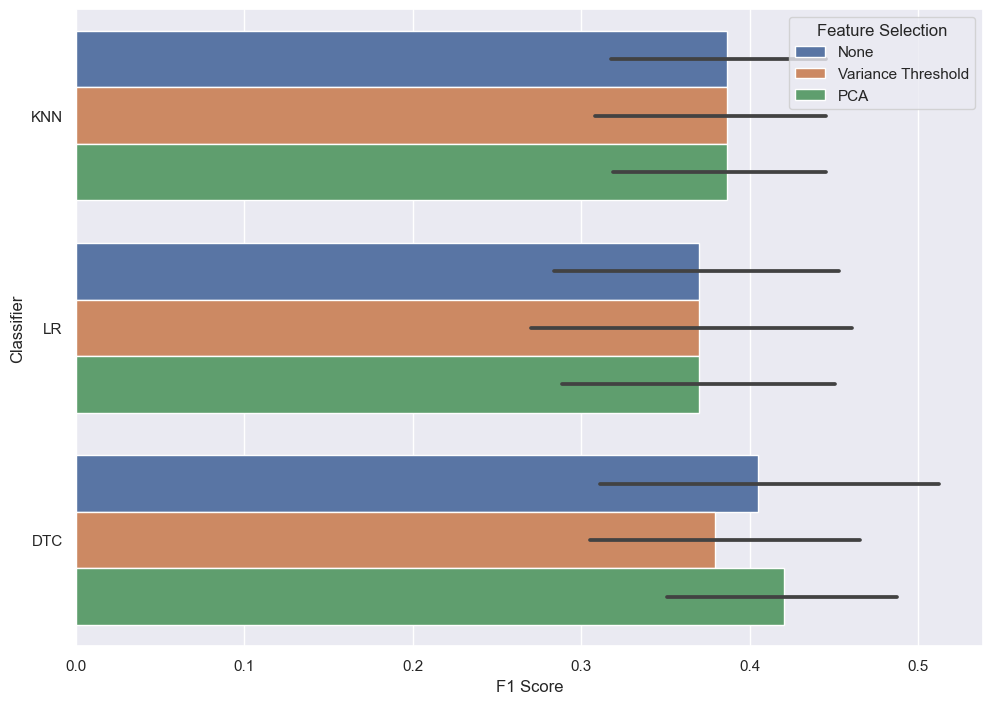

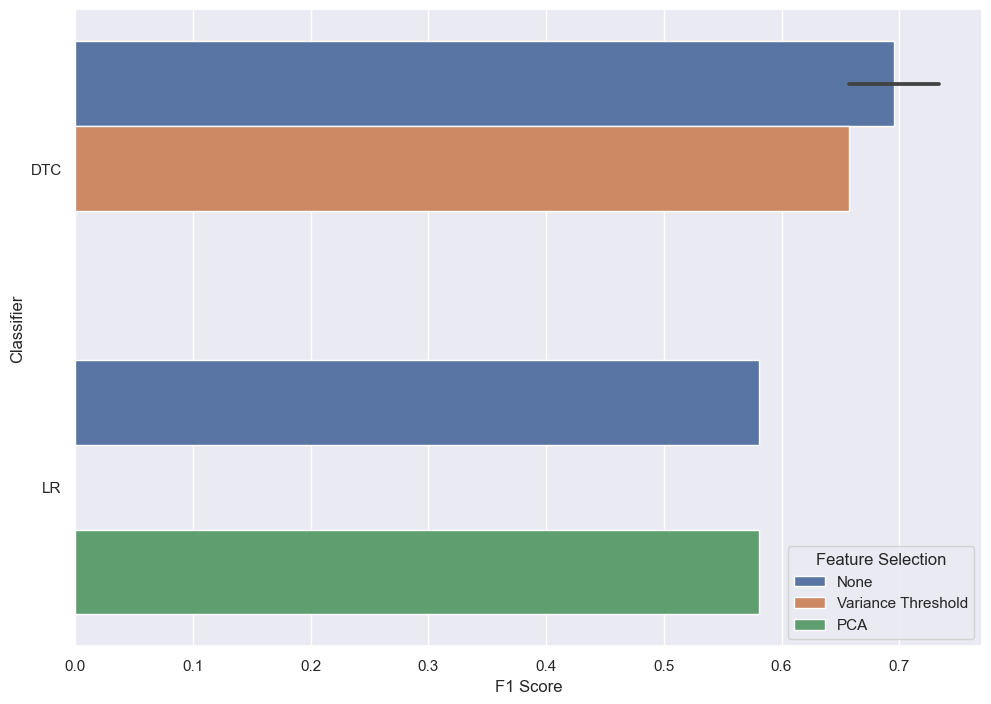

In [97]:
# plot the results
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="F1 Score", y="Classifier", hue="Feature Selection", data=test_results)
plt.show()

# plot the best 3 models
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="F1 Score", y="Classifier", hue="Feature Selection", data=best_models)
plt.show()

**Impact of Dataset Quality**: The quality of images ('Good', 'Mixed', 'Bad') affects the performance of the classifiers. For example, from the table, it seems that classifiers tend to perform worse on 'Bad' images compared to 'Good' or 'Mixed'.

**Effect of Feature Selection**: The type of feature selection method also affects the performance of classifiers. It's a bit harder to draw a definite conclusion on this without more statistical analysis, but it seems like the feature selection method 'PCA' seems to be performing better for 'Mixed' and 'Bad' dataset when using DTC classifier.

**Performance of Classifiers**: The classifiers seem to have varied performance based on the dataset and feature selection method. For example, in the 'Bad' images dataset, DTC seems to have the highest F1 score when 'None' feature selection method is applied.

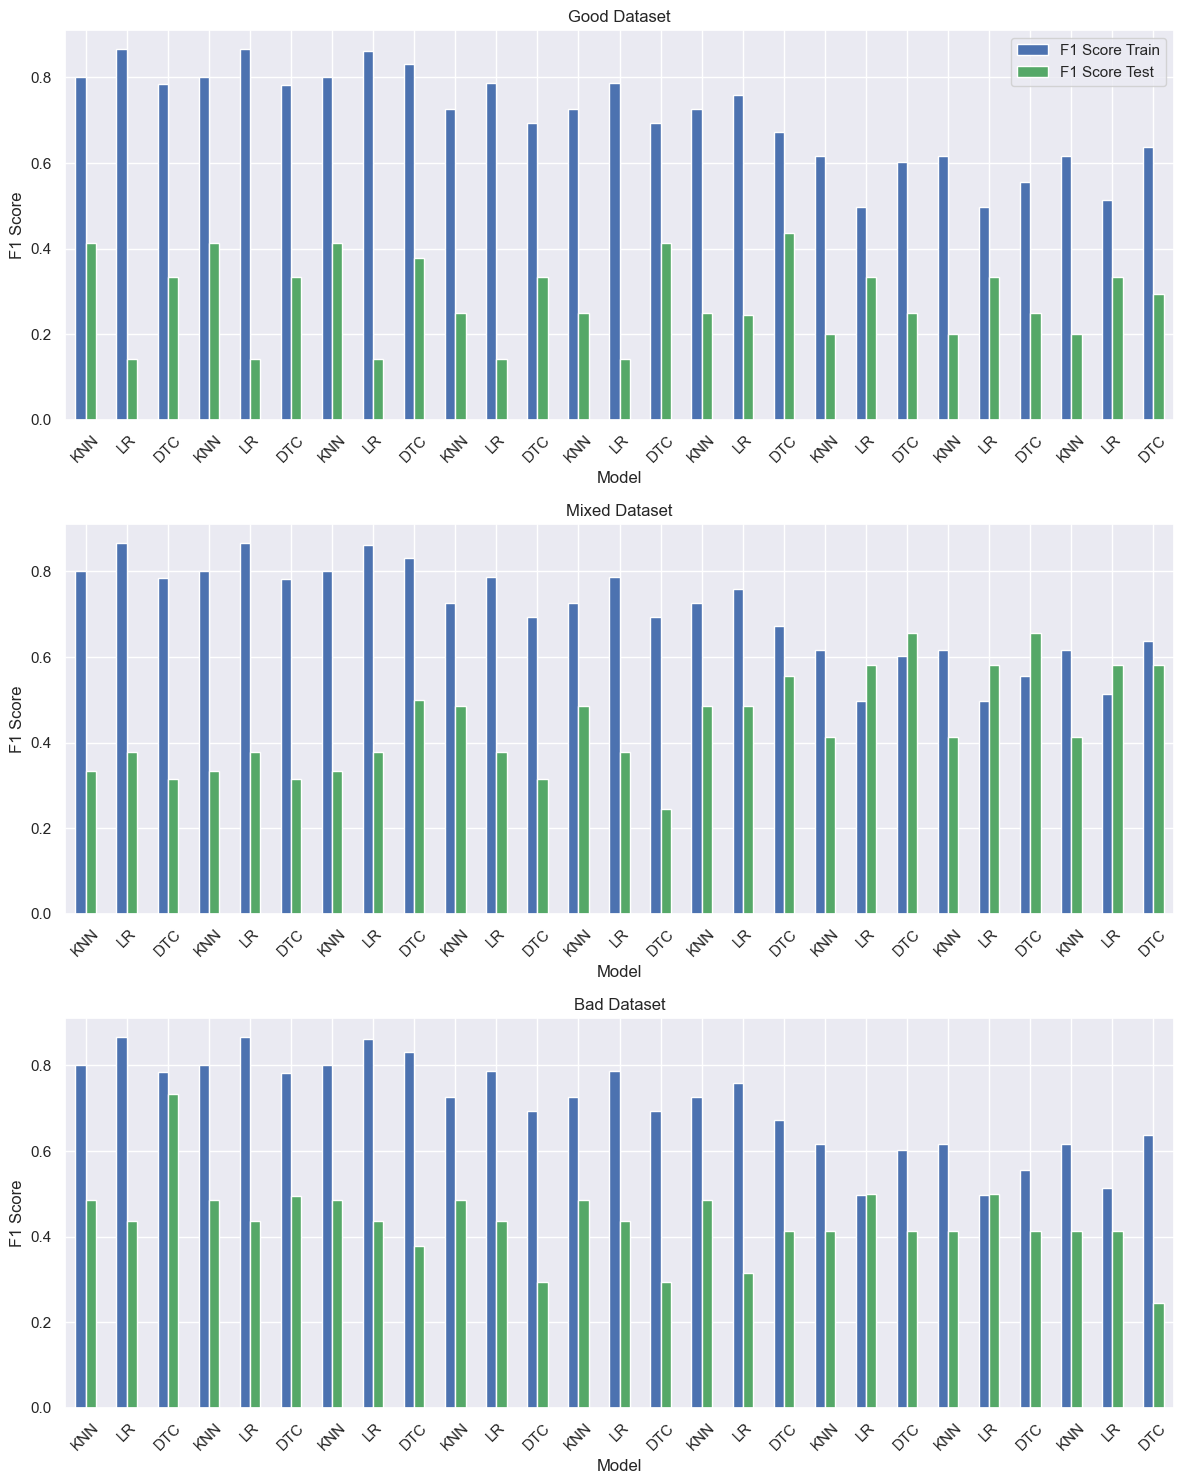

In [98]:
# Load test results for each test dataset separately
good_test_results_df = test_models(path_to_good_test_set, csv_path)
mixed_test_results_df = test_models(path_to_mixed_test_set, csv_path)
bad_test_results_df = test_models(path_to_bad_test_set, csv_path)

# Merge all_results and test_results_df for each test dataset separately
good_merged_results = pd.merge(all_results, good_test_results_df, on=["Dataset", "Feature Selection", "Classifier"], suffixes=("_Train", "_Test"))
mixed_merged_results = pd.merge(all_results, mixed_test_results_df, on=["Dataset", "Feature Selection", "Classifier"], suffixes=("_Train", "_Test"))
bad_merged_results = pd.merge(all_results, bad_test_results_df, on=["Dataset", "Feature Selection", "Classifier"], suffixes=("_Train", "_Test"))

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Set the spacing between subplots
fig.subplots_adjust(hspace=0.5)

# Plot the merged results for each test dataset
good_merged_results.plot(ax=axs[0], x='Classifier', y=['F1 Score_Train', 'F1 Score_Test'], kind='bar', color=['b', 'g'], legend=False)
axs[0].set_title('Good Dataset')

mixed_merged_results.plot(ax=axs[1], x='Classifier', y=['F1 Score_Train', 'F1 Score_Test'], kind='bar', color=['b', 'g'], legend=False)
axs[1].set_title('Mixed Dataset')

bad_merged_results.plot(ax=axs[2], x='Classifier', y=['F1 Score_Train', 'F1 Score_Test'], kind='bar', color=['b', 'g'], legend=False)
axs[2].set_title('Bad Dataset')

# Set the labels and title for each subplot
for ax in axs:
    ax.set_xlabel('Model')
    ax.set_ylabel('F1 Score')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Show the legends
axs[0].legend(['F1 Score Train', 'F1 Score Test'])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# Save the dataframe to a CSV file
good_merged_results.to_csv(r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\merged_results.csv', index=False)

In [106]:
# Merge all_results and test_results_df for each test dataset separately
good_merged_results = pd.merge(all_results, good_test_results_df, on=["Dataset", "Feature Selection", "Classifier"], suffixes=("_Train", "_Test"))
mixed_merged_results = pd.merge(all_results, mixed_test_results_df, on=["Dataset", "Feature Selection", "Classifier"], suffixes=("_Train", "_Test"))
bad_merged_results = pd.merge(all_results, bad_test_results_df, on=["Dataset", "Feature Selection", "Classifier"], suffixes=("_Train", "_Test"))

# Create a merged dataframe with separate columns for F1 TestBad, F1 TestMixed, and F1 TestGood
merged_results = pd.DataFrame()
merged_results["Dataset"] = good_merged_results["Dataset"]
merged_results["Feature Selection"] = good_merged_results["Feature Selection"]
merged_results["Classifier"] = good_merged_results["Classifier"]
merged_results["F1 Score"] = good_merged_results["F1 Score_Train"]
merged_results["Accuracy"] = good_merged_results["Accuracy"]
merged_results["Precision"] = good_merged_results["Precision"]
merged_results["Recall"] = good_merged_results["Recall"]
merged_results["ROC AUC"] = good_merged_results["ROC AUC"]
merged_results["F1 Score_GoodTest"] = good_merged_results["F1 Score_Test"]
merged_results["F1 Score_MixedTest"] = mixed_merged_results["F1 Score_Test"]
merged_results["F1 Score_BadTest"] = bad_merged_results["F1 Score_Test"]

# Display the merged results
merged_results

# Save the merged results to a CSV file
merged_results.to_csv(r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Merged_results.csv', index=False)

In [107]:
merged_results

,Dataset,Feature Selection,Classifier,F1 Score,Accuracy,Precision,Recall,ROC AUC,F1 Score_GoodTest,F1 Score_MixedTest,F1 Score_BadTest
0,Good,None,KNN,0.801014,0.714286,0.771225,0.853634,0.652661,0.412587,0.333333,0.485714
1,Good,None,LR,0.866859,0.819048,0.846891,0.903950,0.795286,0.142857,0.377778,0.437500
2,Good,None,DTC,0.783931,0.695238,0.773144,0.817605,0.643218,0.333333,0.314286,0.733333
3,Good,Variance Threshold,KNN,0.801014,0.714286,0.771225,0.853634,0.652661,0.412587,0.333333,0.485714
4,Good,Variance Threshold,LR,0.866859,0.819048,0.846891,0.903950,0.795286,0.142857,0.377778,0.437500
5,Good,Variance Threshold,DTC,0.782926,0.704762,0.784231,0.798340,0.662677,0.333333,0.314286,0.495798
6,Good,PCA,KNN,0.801014,0.714286,0.771225,0.853634,0.652661,0.412587,0.333333,0.485714
7,Good,PCA,LR,0.860811,0.809524,0.834391,0.903950,0.775286,0.142857,0.377778,0.437500
8,Good,PCA,DTC,0.832177,0.771429,0.843586,0.840399,0.741368,0.377778,0.500000,0.377778
9,Mixed,None,KNN,0.725902,0.649565,0.707633,0.749908,0.609605,0.250000,0.485714,0.485714


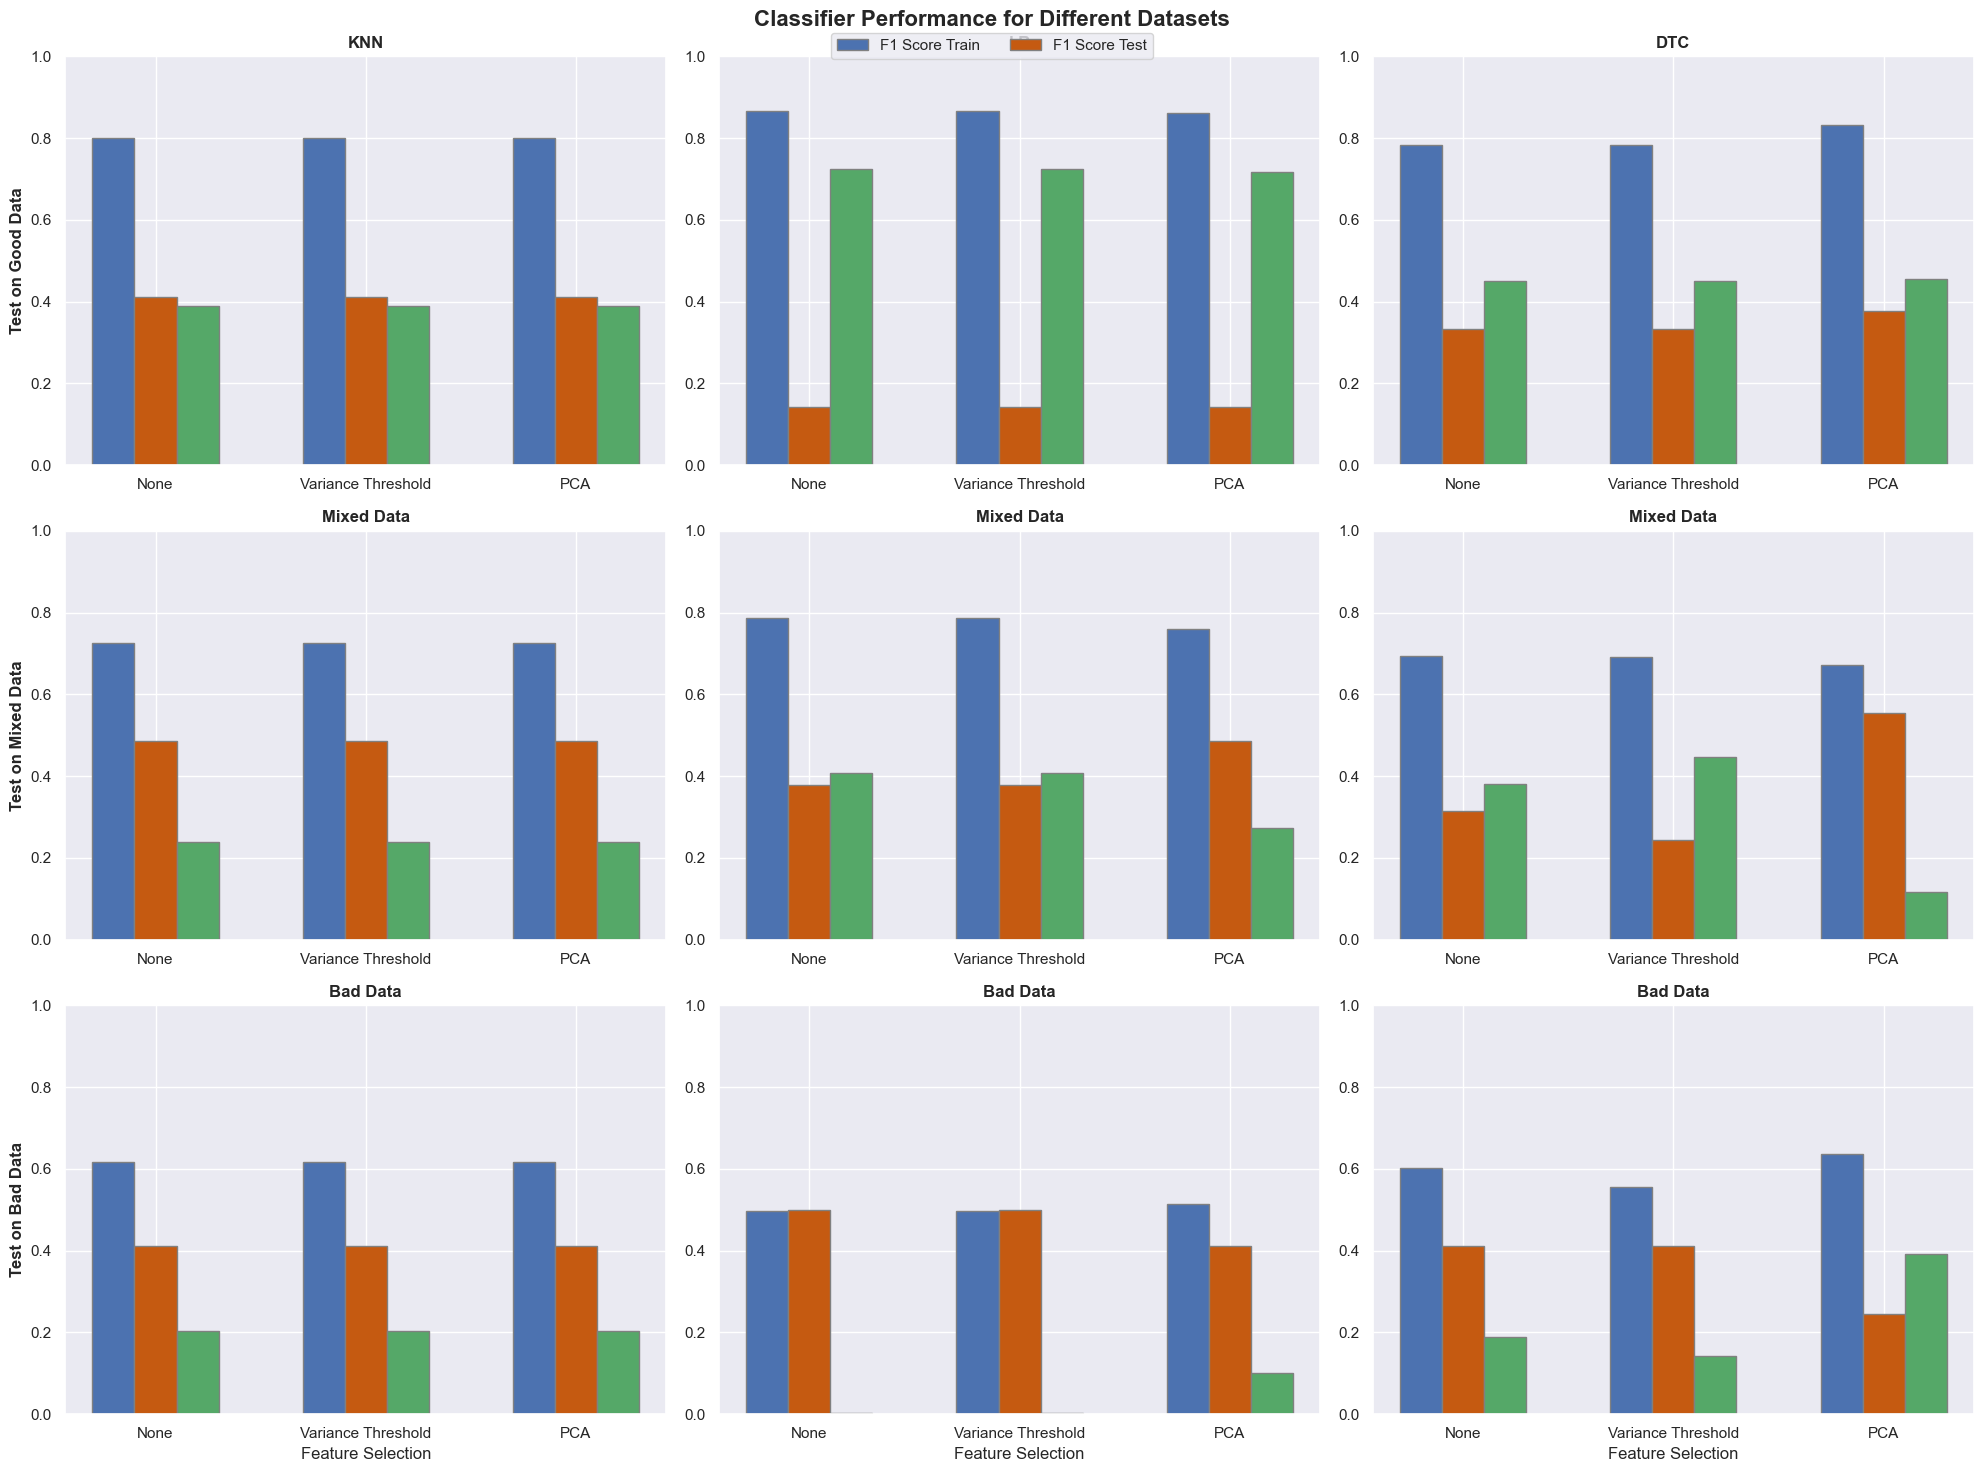

In [130]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv(r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\merged_results.csv')

classifiers = ['KNN', 'LR', 'DTC']
datasets = ['Good', 'Mixed', 'Bad']
test_scores = ['F1 Score_GoodTest', 'F1 Score_MixedTest', 'F1 Score_BadTest']
selection_methods = ['None', 'Variance Threshold', 'PCA']

fig, axs = plt.subplots(3, 3, figsize=(20, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

handles = []
labels = ['F1 Score Train', 'F1 Score Test', 'Difference']

for i, classifier in enumerate(classifiers):
    for j, train_dataset in enumerate(datasets):
        ax = axs[j, i]

        df_subset = df[(df['Classifier'] == classifier) & (df['Dataset'] == train_dataset)]

        bar_width = 0.20
        r1 = np.arange(len(selection_methods))
        r2 = [x + bar_width for x in r1]
        r3 = [x + bar_width for x in r2]

        rects1 = ax.bar(r1, df_subset['F1 Score'], color='b', width=bar_width, edgecolor='grey', label='F1 Score Train')
        rects2 = ax.bar(r2, df_subset[test_scores[j]], color='#C55A11', width=bar_width, edgecolor='grey', label='F1 Score Test')

        # Adding the difference bar
        diff = df_subset['F1 Score'] - df_subset[test_scores[j]]
        rects3 = ax.bar(r3, diff.abs(), color='g', width=bar_width, edgecolor='grey')

        ax.set_title(f'{train_dataset} Data', fontsize=12, fontweight='bold')
        ax.set_xticks([r + bar_width for r in range(len(selection_methods))])
        ax.set_xticklabels(selection_methods)
        ax.set_ylim(0, 1)

        if j == 0:  # Add column labels for the top row
            ax.set_title(f'{classifier}', fontsize=12, fontweight='bold')

        if j == 2:  # Add x-axis label for the bottom row
            ax.set_xlabel('Feature Selection', fontsize=12)

        if i == 0:  # Add row labels for the leftmost column
            ax.set_ylabel(f'Test on {train_dataset} Data', fontsize=12, fontweight='bold')

        if i == 2 and j == 0:  # Grab one set of bars' info for legend
            handles, _ = ax.get_legend_handles_labels()

# Create a shared legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=3)

plt.suptitle('Classifier Performance for Different Datasets', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
